# NNMF with cross-validated number of components

INFO:


TODO:
- plot repeated nnmf_cv results and find cutoff at CI95

In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1' # limit env var for multithreading > avoids numpy-vs-multiprocessing conflict (do before numpy import)

In [2]:
# Library/module setup
from cv import * # NNMF cross-validation functions

import glob # file browsing
from scipy import stats
import scipy.io as sio # data input/output

import multiprocessing # parallel computing

import time # timing computations
import datetime
import logging # log outputs allows to disconnect from notebook

import matplotlib.pyplot as plt # plotting lib
%matplotlib inline

%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.4/dist-packages/matplotlib/cbook.py:128: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the matplotlib toolkit finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [3]:
# Load PSTH data (.mat file)
orig_data = sio.loadmat('../data/nnmf_best.mat')
sio.whosmat('../data/nnmf_best.mat')

[('A', (641, 25), 'double'),
 ('D_res', (100, 1), 'double'),
 ('X', (641, 815), 'double'),
 ('Y', (25, 815), 'double'),
 ('k_best', (1, 1), 'double'),
 ('psth', (1, 1), 'struct')]

In [4]:
# Extract PSTH data
data = orig_data['psth']['psth'][0,0] # PSTH array is in nnmf_best.psth.psth
print('data: firing rate PSTH of %i cells x %i tPoints' % data.shape)

data: firing rate PSTH of 815 cells x 641 tPoints


# Fit NNMF model

In [5]:
# Parameters
ranks = [[x] for x in range(1,71)] # range of components to test (NOTE: range(1,11) = ranks 1-10)
repetitions = range(202,203) # number of repetitions; given as range to control repetition_ID (used for rng)
iterator = [(i[0],j) for (i,j) in itertools.product(ranks, repetitions)]

In [6]:
iterator

[(1, 202),
 (2, 202),
 (3, 202),
 (4, 202),
 (5, 202),
 (6, 202),
 (7, 202),
 (8, 202),
 (9, 202),
 (10, 202),
 (11, 202),
 (12, 202),
 (13, 202),
 (14, 202),
 (15, 202),
 (16, 202),
 (17, 202),
 (18, 202),
 (19, 202),
 (20, 202),
 (21, 202),
 (22, 202),
 (23, 202),
 (24, 202),
 (25, 202),
 (26, 202),
 (27, 202),
 (28, 202),
 (29, 202),
 (30, 202),
 (31, 202),
 (32, 202),
 (33, 202),
 (34, 202),
 (35, 202),
 (36, 202),
 (37, 202),
 (38, 202),
 (39, 202),
 (40, 202),
 (41, 202),
 (42, 202),
 (43, 202),
 (44, 202),
 (45, 202),
 (46, 202),
 (47, 202),
 (48, 202),
 (49, 202),
 (50, 202),
 (51, 202),
 (52, 202),
 (53, 202),
 (54, 202),
 (55, 202),
 (56, 202),
 (57, 202),
 (58, 202),
 (59, 202),
 (60, 202),
 (61, 202),
 (62, 202),
 (63, 202),
 (64, 202),
 (65, 202),
 (66, 202),
 (67, 202),
 (68, 202),
 (69, 202),
 (70, 202)]

In [7]:
fname = ('logfile_%i-%i_%i-%i' % (ranks[0][0], ranks[-1][0], repetitions[0], repetitions[-1]))
fname

'logfile_1-70_202-202'

In [8]:
def nnmf_parallel(rank, repetition, data=data):
    
    ## Set random number generator seed 
    # This is necessary to get different results from multiprocessing.
    # One method is to set the seed to current time. Here, we convert sub-second values to int, because 
    # otherwise, parallel processes starting within the same second will have the same seed.
#     seed = int(str(time.time()).split(".")[1])
    # Another method to easily set reproducible seeds per rank and repetition is this one:
    seed = int(''.join((str(rank), str(repetition)))) # set reproducible seed
    np.random.seed(seed=seed)    

    # Write log
    print('  Fitting model:   rank: %i, repetition: %i, seed: %i ...' % (rank, repetition, seed))
    logging.info('  Fitting model:   rank: %i, repetition: %i, seed: %i ...' % (rank, repetition, seed))
    
    # Run model
    train_err, test_err = cv_pca(data, rank, M=None, p_holdout=0.3, nonneg=True)[2:]    
        
    return (rank, train_err, test_err, seed)

In [ ]:
# Run nnmf_parallel() in parallel

# Pars
n_processes = multiprocessing.cpu_count()-4 # define number of kernels

# Write log
fname = ('logfile_%i-%i_%i-%i' % (ranks[0][0], ranks[-1][0], repetitions[0], repetitions[-1]))
logging.basicConfig(level=logging.DEBUG, filename=fname, filemode="a+",
                    format="%(asctime)-15s %(levelname)-8s %(message)s")
print('Fitting model for ranks %i-%i with repetition %i-%i.' \
      % (np.min(ranks), np.max(ranks), repetitions[0], repetitions[-1]))
logging.info('Fitting model for ranks %i-%i with %i repetition(s).' \
      % (np.min(ranks), np.max(ranks), repetitions[-1]-repetitions[0]+1))

# Split per repetition and rank for now to run code in chunks during debug (can later create bigger chunks, e.g. np.array_split())
# NOTE: remove once runtime problems are resolved
t = time.time()
for rep in repetitions:
    chunk_size = 20 # ranke chunk size
    ranks_chunk = [ranks[i:i+chunk_size] for i in range(0,len(ranks), chunk_size)] # split into rank chunks
    for rnk in range(len(ranks_chunk)):        

        tt = time.time()
        train_err, test_err, seeds, temp, nnmf_cv_err_per_comp = [], [], [], None, None # initialize vars

        iterator = [(i[0],j) for (i,j) in itertools.product(ranks_chunk[rnk], range(rep,rep+1))]
        
        # Fit NNMF model (parallel implementation)
        print('Running parallelization with %i processes.' % n_processes)
        with multiprocessing.Pool(processes=n_processes) as pool:
            temp = pool.starmap(nnmf_parallel, iterator)

        train_err = [(i[0], i[1]) for i in temp]
        test_err = [(i[0], i[2]) for i in temp]
        seeds = [(i[3]) for i in temp]

        dur = round(time.time() - tt)
        print('DONE repetition %i, ranks %i-%i! Execution time: %s (h:min:sec).' 
              % (rep, ranks_chunk[rnk][0][0], ranks_chunk[rnk][-1][0], str(datetime.timedelta(seconds=dur))))
        logging.info('DONE! Execution time: %s (h:min:sec).' % str(datetime.timedelta(seconds=dur)))

        # Save results
        do_save = True
        if do_save:
            nnmf_cv_err_per_comp = {'train_err': train_err, 'test_err': test_err, 'seeds': seeds}
            fname = ('../data/nnmf_cv_err_per_comp_%i-%i_%i-%i' 
                     % (np.min([j[0] for j in iterator]), np.max([j[0] for j in iterator]),
                        np.min([j[1] for j in iterator]), np.max([j[1] for j in iterator])))
            print(fname)
            np.save(fname, nnmf_cv_err_per_comp)

dur = round(time.time() - t)            
print('DONE for ranks %i-%i with repetition %i-%i. Execution time: %s (h:min:sec).' \
      % (np.min(ranks), np.max(ranks), repetitions[0], repetitions[-1], dur))
logging.info('DONE for ranks %i-%i with repetition %i-%i. Execution time: %s (h:min:sec).(s).' \
      % (np.min(ranks), np.max(ranks), repetitions[-1]-repetitions[0]+1, dur))            

Fitting model for ranks 1-70 with repetition 202-202.
Running parallelization with 20 processes.
  Fitting model:   rank: 1, repetition: 202, seed: 1202 ...
  Fitting model:   rank: 4, repetition: 202, seed: 4202 ...
  Fitting model:   rank: 2, repetition: 202, seed: 2202 ...
  Fitting model:   rank: 5, repetition: 202, seed: 5202 ...
  Fitting model:   rank: 3, repetition: 202, seed: 3202 ...
  Fitting model:   rank: 6, repetition: 202, seed: 6202 ...
  Fitting model:   rank: 8, repetition: 202, seed: 8202 ...
  Fitting model:   rank: 9, repetition: 202, seed: 9202 ...
  Fitting model:   rank: 10, repetition: 202, seed: 10202 ...
  Fitting model:   rank: 7, repetition: 202, seed: 7202 ...
  Fitting model:   rank: 11, repetition: 202, seed: 11202 ...
  Fitting model:   rank: 15, repetition: 202, seed: 15202 ...
  Fitting model:   rank: 17, repetition: 202, seed: 17202 ...
  Fitting model:   rank: 14, repetition: 202, seed: 14202 ...
  Fitting model:   rank: 18, repetition: 202, seed: 1

# Data assembler
Due to the analysis duration, the analysis results were continuously saved to files in chunks and need to be reassembled here

In [9]:
# Find all matching files
file_list = glob.glob('../data/nnmf_cv_err_per_comp_*')
print('Files found:')
print(*file_list, sep='\n')

test_err, train_err, seeds = [], [], [] # initialize vars

# Assemble data from all files
for f in file_list:
    print('Loading %s' % f)
    dat = np.load(f).item()

    # Add data to list
    test_err.extend(dat['test_err'])
    train_err.extend(dat['train_err'])
    seeds.extend(dat['seeds'])

# Remove duplicates
tr, te, s = [], [], []
for idx,val in enumerate(test_err):
    if val not in te:
        te.append(val), tr.append(train_err[idx]), s.append(seeds[idx])
print("Removing %i duplicates." % (len(test_err) - len(te)))
train_err, test_err, seeds = tr, te, s
print('Saving %i data points.' % len(train_err))    

# Save summary file
do_save = True
if do_save:
    nnmf_cv_err_per_comp = {'train_err': train_err, 'test_err': test_err, 'seeds': seeds}
    fname = '../data/nnmf_cv_err_per_comp-all'
    print('Saving data summary file: %s' % fname)
    np.save(fname, nnmf_cv_err_per_comp)

Files found:
../data/nnmf_cv_err_per_comp_61-70_107-107.npy
../data/nnmf_cv_err_per_comp_61-70_131-131.npy
../data/nnmf_cv_err_per_comp_41-60_52-52.npy
../data/nnmf_cv_err_per_comp_21-40_89-89.npy
../data/nnmf_cv_err_per_comp_1-20_86-86.npy
../data/nnmf_cv_err_per_comp_31-70_16-16.npy
../data/nnmf_cv_err_per_comp_61-70_74-74.npy
../data/nnmf_cv_err_per_comp_41-60_134-134.npy
../data/nnmf_cv_err_per_comp_1-20_53-53.npy
../data/nnmf_cv_err_per_comp_21-40_102-102.npy
../data/nnmf_cv_err_per_comp_61-70_47-47.npy
../data/nnmf_cv_err_per_comp_1-20_126-126.npy
../data/nnmf_cv_err_per_comp_1-20_102-102.npy
../data/nnmf_cv_err_per_comp_41-60_66-66.npy
../data/nnmf_cv_err_per_comp_21-40_110-110.npy
../data/nnmf_cv_err_per_comp_61-70_51-51.npy
../data/nnmf_cv_err_per_comp_44-44_106-106.npy
../data/nnmf_cv_err_per_comp_1-20_85-85.npy
../data/nnmf_cv_err_per_comp_1-20_120-120.npy
../data/nnmf_cv_err_per_comp_61-70_137-137.npy
../data/nnmf_cv_err_per_comp_1-20_91-91.npy
../data/nnmf_cv_err_per_comp_

In [10]:
# Load data if it doesn't exist in workspace
del nnmf_cv_err_per_comp
if not ('nnmf_cv_err_per_comp' in locals() or 'nnmf_cv_err_per_comp' in globals()):
    dat       = np.load('../data/nnmf_cv_err_per_comp-all.npy').item()
    test_err  = dat['test_err']
    train_err = dat['train_err']
    seeds     = dat['seeds']
print(len(train_err)), print(len(test_err)), print(len(seeds))

9598


# Plot

In [11]:
def defaultPlotPars():
    """Defines default plot parameters by changing rcParams.
    TODO: 
        - See if need to output other plot params that cannot be changed in rcParams. 
        - Allow for dict input of parameters.
    """
    from pylab import rcParams as rc

    plot_par = {'font.size': 13.0,
           'axes.linewidth': 1,
           'axes.labelsize': 'large',
           'axes.titlesize': 'large',
           'xtick.labelsize': 'medium',
           'ytick.labelsize': 'medium',
           }
    rc.update(plot_par)
    
    return rc, plot_par

In [12]:
rc, plot_par = defaultPlotPars()

In [13]:
## Plot cross-validated train vs test errors
def plot_nnmf_cv_err(train_err, test_err, save_fig=False):
    '''plot_nnmf_cv_err(train_err, test_err)
    Plots cross-validated NNMF errors for training vs test set.
    TODO: decide on vertical line par
    '''
    ## Pars    
    cmap = plt.cm.Set1(np.linspace(0,1,9)) # load colormap: Dark2
    tr_col, te_col = cmap[1], cmap[0] #cmap[0], cmap[1]
    
    ## Calculations
    tr = np.array([i[1] for i in train_err])
    te = np.array([i[1] for i in test_err])
    rank = np.array([i[0] for i in train_err])
    ranks = np.unique(np.unique([i[0] for i in train_err]))

    # Mean, SD, CI
    mean_train, sd_train = [np.mean(tr[rnk==rank]) for rnk in ranks], [np.std(tr[rnk==rank]) for rnk in ranks]
    mean_test, sd_test = [np.mean(te[rnk==rank]) for rnk in ranks], [np.std(te[rnk==rank]) for rnk in ranks]
    N = [len(tr[rnk==rank]) for rnk in ranks]
#     ci_train_norm = stats.norm.interval(0.95, loc=mean_train, scale = sd_train/np.sqrt(N))
    ci_train_t    = stats.t.interval(0.95, df=N, loc=mean_train, scale = sd_train/np.sqrt(N))
#     ci_test_norm  = stats.norm.interval(0.95, loc=mean_test, scale = sd_test/np.sqrt(N))
    ci_test_t     = stats.t.interval(0.95, df=N, loc=mean_test, scale = sd_test/np.sqrt(N))
    
    # Find rank / number of components with smallest MSE
    min_err = test_err[np.argmin([x[1] for x in test_err])] # min(MSE) single data point
    print('Number of components with single minimal MSE: %i (MSE: %f)' % (min_err[0], min_err[1]))
    min_err_mean = (idx, val) = np.argmin(mean_test)+1, np.min(mean_test) # min(mean_MSE)
    print('Number of components with mean minimal MSE: %i (MSE: %f)' % (min_err_mean[0], min_err_mean[1]))

    ## Plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    # Single data points
    ax.plot(*list(zip(*train_err)), linestyle='', marker='o', color=tr_col, markerfacecolor='None', alpha=0.3, label='Train Data')
    ax.plot(*list(zip(*test_err)), linestyle='', marker='o', color=te_col, markerfacecolor='None', alpha=0.3, label='Test Data')
    # Means
    ax.plot(ranks, mean_train, color=tr_col, label='mean(Train)')
    ax.plot(ranks, mean_test, color=te_col, label='mean(Test)')
    # CIs
    ax.fill_between(ranks, ci_train_t[0], ci_train_t[1], facecolor=tr_col, alpha=0.3, label='CI$_{95}$(Train)')
    ax.fill_between(ranks, ci_test_t[0], ci_test_t[1], facecolor=te_col, alpha=0.3, label='CI$_{95}$(Train)')
    
    ax.set_ylabel('Mean Squared Error')
    ax.set_xlabel('Number of components')
    ax.set_title('NNMF \n N$_{repetitions}$ = %i' %int(np.mean(N)))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend()
    fig.tight_layout()
#     ax.set_xlim((10,20))
    ax.set_ylim((0,0.05))
    
    # Mark optimal rank criteria
    ax.axvline(min_err[0], color='k', dashes=[2,2]) # optimal rank single
    ax.text(min_err[0]-1, ax.get_ylim()[1]-0.01, 'min(MSE$_{single}$) \nN = %i' % min_err[0],
            verticalalignment='top', horizontalalignment='right')
    ax.axvline(min_err_mean[0], color='k', dashes=[2,2]) # optimal rank mean
    ax.text(min_err_mean[0]-1, ax.get_ylim()[1]-0.01, 'min(MSE$_{mean}$) \nN = %i' % min_err_mean[0],
            verticalalignment='top', horizontalalignment='right')
  
    #plt.show()
    if save_fig:
        fig.savefig('../figures/nnmf_crossval_curves.pdf')
        fig.savefig('../figures/nnmf_crossval_curves.png')
        
    return fig, ax

Number of components with single minimal MSE: 66 (MSE: 0.006721)
Number of components with mean minimal MSE: 34 (MSE: 0.007651)


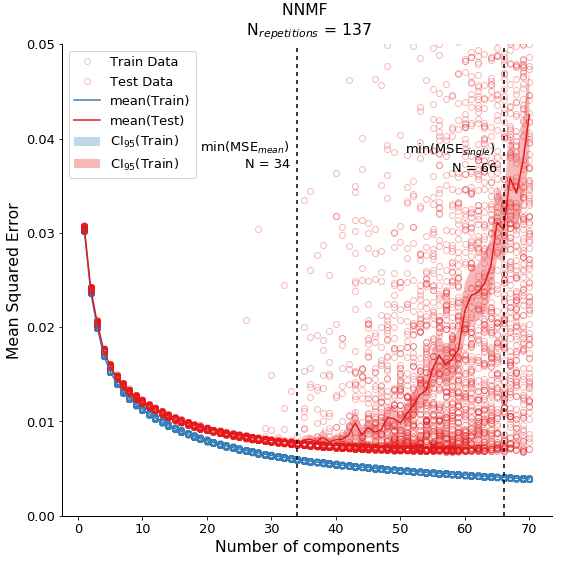

In [14]:
fig, ax = plot_nnmf_cv_err(train_err, test_err)

Number of components with single minimal MSE: 66 (MSE: 0.006721)
Number of components with mean minimal MSE: 34 (MSE: 0.007651)


(0, 0.02)

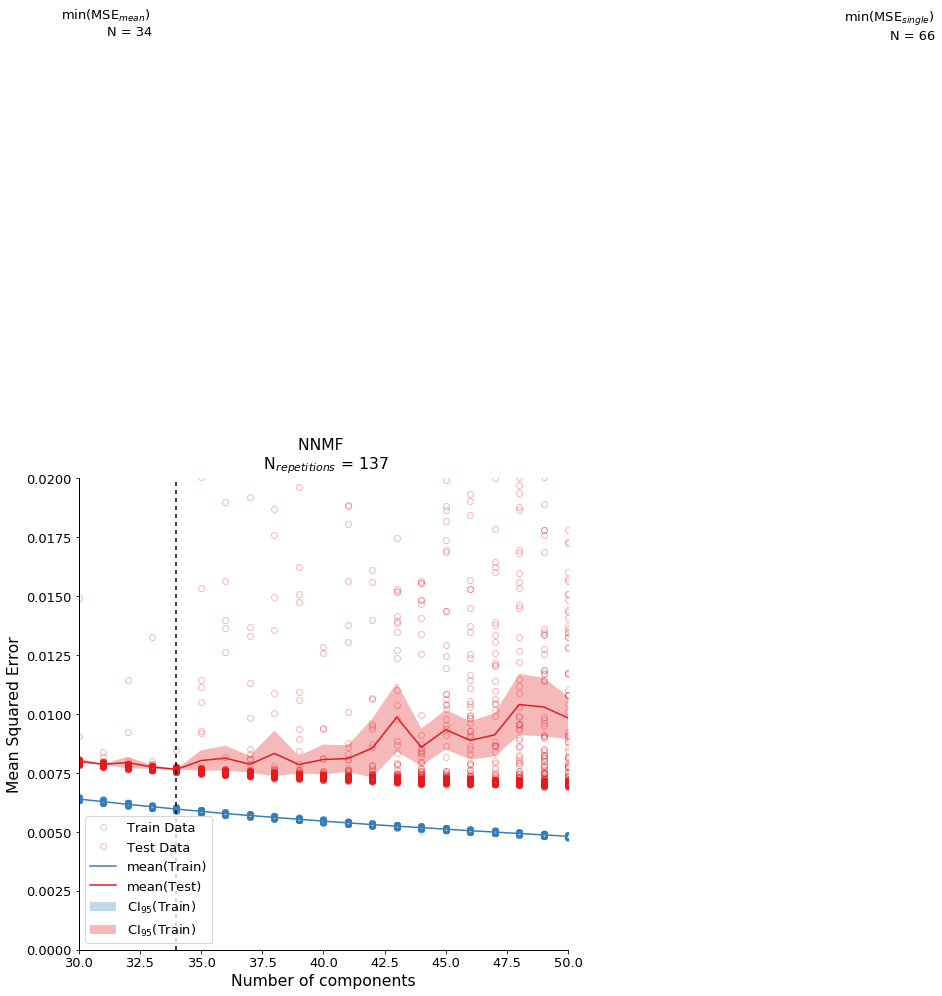

In [15]:
fig, ax = plot_nnmf_cv_err(train_err, test_err)
ax.set_xlim((30,50))
ax.set_ylim((0,0.02))

In [40]:
# Get ratio of cross-validated train vs test errors
a = [i[1] for i in test_err]
b = [i[1] for i in train_err]
ratio = np.array([i / j for i,j in zip(a,b)])
len(ratio)

3105

In [41]:
rank = np.array([i[0] for i in train_err])
ranks = np.unique(np.unique([i[0] for i in train_err]))

# Mean, SD, CI
mean_ratio = [np.mean(ratio[rnk==rank]) for rnk in ranks]

3105

In [52]:
## Plot ratio of cross-validated train vs test errors

def plot_nnmf_cv_err_ratio(train_err, test_err, save_fig=False):
    '''plot_nnmf_cv_err_ratio(train_err, test_err, save_fig=False):
    Plots ratio of cross-validated NNMF errors for training vs test set.
    '''
    # Pars
    ratio_cut = 1.1
    ylim_cut = 3
    
    ## Calculations
    # Get ratio of cross-validated train vs test errors
    tr = np.array([i[1] for i in train_err])
    te = np.array([i[1] for i in test_err])
    ratio = np.array([i / j for i,j in zip(te,tr)])
    
    rank = np.array([i[0] for i in train_err])
    ranks = np.unique(np.unique([i[0] for i in train_err]))

    # Mean
    mean_ratio = [np.mean(ratio[rnk==rank]) for rnk in ranks]
    mean_test = [np.mean(te[rnk==rank]) for rnk in ranks]

    # Find rank / number of components with smallest MSE
    min_err = test_err[np.argmin([x[1] for x in test_err])] # min(MSE) single data point
    print('Number of components with single minimal MSE: %i (MSE: %f)' % (min_err[0], min_err[1]))
    min_err_mean = (idx, val) = np.argmin(mean_test)+1, np.min(mean_test) # min(mean_MSE)
    print('Number of components with mean minimal MSE: %i (MSE: %f)' % (min_err_mean[0], min_err_mean[1]))    

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.plot(mean_ratio, 'o-', color='purple') # label='ratio(test_err / train_err)')
    # ax.set_ylabel('$MSE_{test}$ / $MSE_{train}$')
    ax.set_ylabel('$\\frac{MSE_{test}}{MSE_{train}}$', Fontsize=20)
    ax.set_xlabel('Number of components')
    ax.set_title('NNMF')
    ax.set_ylim(0, ylim_cut)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Mark optimal rank criteria
    ax.axvline(min_err[0], color='k', dashes=[2,2]) # optimal rank single
    ax.text(min_err[0]-1, ax.get_ylim()[1], 'min(MSE$_{single}$) \nN = %i' % min_err[0], Fontsize=12,
            verticalalignment='top', horizontalalignment='right')
    ax.axvline(min_err_mean[0], color='k', dashes=[2,2]) # optimal rank mean
    ax.text(min_err_mean[0]-1, ax.get_ylim()[1], 'min(MSE$_{mean}$) \nN = %i' % min_err_mean[0], Fontsize=12,
            verticalalignment='top', horizontalalignment='right')

    ax.axhline(ratio_cut, color='k', dashes=[2,2]) # horizontal line for ratio cut-off
    ax.text(ax.get_xlim()[1], ratio_cut, 'ratio = %.1f'%ratio_cut,
            Fontsize=12, verticalalignment='bottom', horizontalalignment='right')

    ax.legend()
    fig.tight_layout()

    if save_fig:
        fig.savefig('../figures/nnmf_crossval_curves_ratio.pdf')
        fig.savefig('../figures/nnmf_crossval_curves_ratio.png')

Number of components with single minimal MSE: 57 (MSE: 0.006791)
Number of components with mean minimal MSE: 34 (MSE: 0.007648)


/Users/ybauer/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


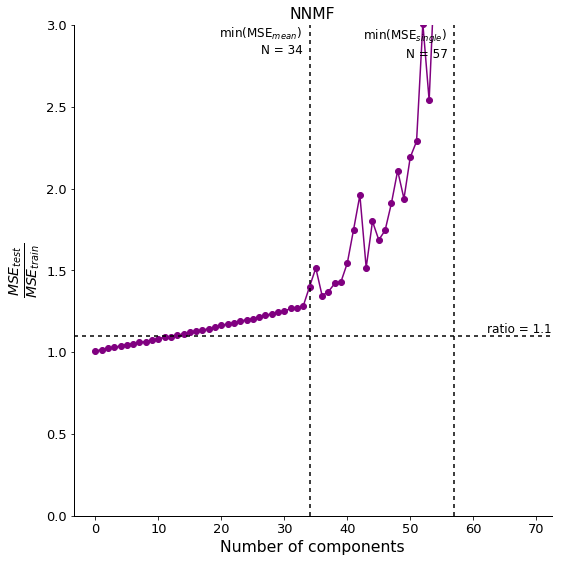

In [91]:
plot_nnmf_cv_err_ratio(train_err, test_err, save_fig=False)

# Fit model w desired number of components

In [223]:
data.shape

(815, 641)

In [249]:
# Define rank / number of components
rank = 30 # opt_rank[0]

# Fit model with optimal number of components
print('Fitting model with %i components...' %rank)
U, Vt, tr_err, te_err = cv_pca(data, rank, nonneg=True)

print('U: Cells and their component weights \t [n_cells x n_components] =', U.shape)
print('Vt: Components and their time weights \t [n_componetns x n_tPoints] =', Vt.shape)

Fitting model with 30 components...
U: Cells and their component weights 	 [n_cells x n_components] = (815, 30)
Vt: Components and their time weights 	 [n_componetns x n_tPoints] = (30, 641)


In [250]:
# Save components for plotting

do_save = True

if do_save:
    # Save as .mat struct to use Miro's plotting scripts
    print('Saving to: '+'../data/nnmf_cv_comps.mat')
    sio.savemat('../data/nnmf_cv_comps.mat',
                {'U': U,
                 'Vt': Vt,
                 'tr_err': tr_err,
                 'te_err': te_err,
                })

Saving to: ../data/nnmf_cv_comps.mat


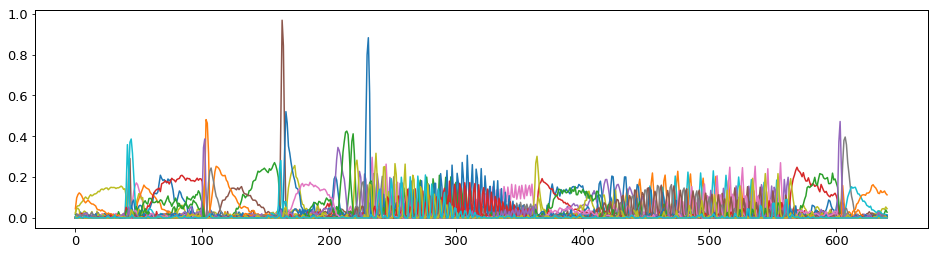

In [248]:
# Plot components
fig, ax = plt.subplots(1, 1, figsize=(16,4))

ax.plot(Vt.T)
plt.show()


# TESTS

In [2]:
# Do dry run with artificial data generated by plot_nmf()
plot_nmf()

Fitting model with rank 1/7 ...
Fitting model with rank 2/7 ...
Fitting model with rank 3/7 ...
Fitting model with rank 4/7 ...
Fitting model with rank 5/7 ...
Fitting model with rank 6/7 ...
Fitting model with rank 7/7 ...
DONE.


In [24]:
# Parameters
# N, R = 150, 4
# noise = .8
repetitions = 2
ranks = np.arange(1, 3)

In [5]:
# Initialize problem
# U = np.random.rand(N, R)
# Vt = np.random.rand(R, N)
# data = np.dot(U, Vt) + noise*np.random.rand(N, N)
# train_err, test_err = [], []

In [25]:
# Fit NNMF models w various k components

train_err, test_err = [], [] # initialize problem

t = time.time() # get execution time
for rnk, _ in itertools.product(ranks, range(repetitions)):
    print('Fitting model with rank %i/%i ...' % (rnk, ranks[-1]))
    tr, te = cv_pca(data, rnk, nonneg=True)[2:]
    train_err.append((rnk, tr))
    test_err.append((rnk, te))
    
print('DONE! Execution time: %i s.' % round(time.time() - t))

Fitting model with rank 1/2 ...
Fitting model with rank 1/2 ...
Fitting model with rank 2/2 ...
Fitting model with rank 2/2 ...
DONE! Execution time: 91 s.


In [9]:
tr, te = cv_pca(data, 30, nonneg=True)[2:]

## test progress bar

In [6]:
# Progress bar
# from tqdm import tqdm
# pbar = tqdm(total=len(iterator))

## Test threading control

In [4]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import multiprocessing
import obspy


def process(*args):
    st = obspy.read()
    # Uses problematic BLAS function.
    st.detrend("linear")

p = multiprocessing.Pool(processes=2)
p.map(process, xrange(50))

ImportError: No module named 'obspy'

In [1]:
import os
os.environ
os.environ['OPENBLAS_NUM_THREADS'] = '1' # limit environment variable for multithreading to avoid multiprocessing interference
# %env OPENBLAS_NUM_THREADS=1 # same as global var
# %env MKL_NUM_THREADS=1 # other candidates
# %env NUMEXPR_NUM_THREADS=1 # other candidates


In [4]:
t = time.time()
tr, te = cv_pca(data, 41, nonneg=True)[2:]
dur = time.time() - t

KeyboardInterrupt: 

In [5]:
print('time for rank:15, w multithreading on cn31: %s (h:min:sec).' % str(datetime.timedelta(seconds=dur)))

NameError: name 'dur' is not defined

In [4]:
import os

os.listdir('.')


['._.DS_Store',
 'nnmf_crossval.ipynb',
 'nnmf_crossval-Copy1.ipynb',
 'nnmf_crossval-Copy6.ipynb',
 'logfile_31-40_2-2',
 'logfile_31-70_7-7',
 '._Icon\r',
 'logfile_1-5_1-1',
 '.ipynb_checkpoints',
 'nnmf_crossval-Copy4.ipynb',
 'logfile_31-70_11-20',
 'nnmf_crossval-Copy5.ipynb',
 'cv.py',
 '._.ipynb_checkpoints',
 'nnmf_crossval-Copy3.ipynb',
 'nnmf_crossval-Copy8.ipynb',
 'logfile_31-70_4-4',
 'Icon\r',
 '.DS_Store',
 'nnmf_crossval-Copy2.ipynb',
 'nnmf_crossval-Copy7.ipynb',
 '.___pycache__',
 'nnmf_crossval_archive.ipynb',
 'logfile_1-30_21-30',
 'nnmf_crossval-Copy9.ipynb',
 '__pycache__',
 'logfile_45-50_2-2',
 '.git',
 'nnls.py',
 'logfile_31-70_5-5',
 'nnmf_crossval-Copy10.ipynb',
 'logfile_51-70_2-2']

In [10]:
file_list[0]

'../data/nnmf_cv_err_per_comp_31-70_4-4.npy'

In [35]:
del seeds


In [41]:
print(['Files found:' + file_list])

TypeError: must be str, not list

In [44]:
glob.glob('../data/nnmf_cv_err_per_comp_*')

['../data/nnmf_cv_err_per_comp_31-70_4-4.npy',
 '../data/nnmf_cv_err_per_comp_1-30_16-16.npy',
 '../data/nnmf_cv_err_per_comp_11-20_1-10.npy',
 '../data/nnmf_cv_err_per_comp_21-30_1-10.npy',
 '../data/nnmf_cv_err_per_comp_51-70_2-2.npy',
 '../data/nnmf_cv_err_per_comp_31-70_11-11.npy',
 '../data/nnmf_cv_err_per_comp_1-30_22-22.npy',
 '../data/nnmf_cv_err_per_comp_1-30_13-13.npy',
 '../data/nnmf_cv_err_per_comp_31-70_8-8.npy',
 '../data/nnmf_cv_err_per_comp_31-40_2-2.npy',
 '../data/nnmf_cv_err_per_comp_31-70_10-10.npy',
 '../data/nnmf_cv_err_per_comp_1-30_11-11.npy',
 '../data/nnmf_cv_err_per_comp_31-70_7-7.npy',
 '../data/nnmf_cv_err_per_comp_51-70_1-1.npy',
 '../data/nnmf_cv_err_per_comp_31-50_1-1.npy',
 '../data/nnmf_cv_err_per_comp_1-30_23-23.npy',
 '../data/nnmf_cv_err_per_comp_1-30_21-21.npy',
 '../data/nnmf_cv_err_per_comp_45-50_2-2.npy',
 '../data/nnmf_cv_err_per_comp_1-10_1-10.npy',
 '../data/nnmf_cv_err_per_comp_31-70_9-9.npy',
 '../data/nnmf_cv_err_per_comp_1-30_15-15.npy',


In [ ]:
# Run nnmf_parallel() in parallel

# Write log
fname = ('logfile_%i-%i_%i-%i' % (ranks[0][0], ranks[-1][0], repetitions[0], repetitions[-1]))
logging.basicConfig(level=logging.DEBUG, filename=fname, filemode="a+",
                    format="%(asctime)-15s %(levelname)-8s %(message)s")
print('Fitting model for ranks %i-%i with %i repetition(s).' \
      % (np.min(ranks), np.max(ranks), repetitions[-1]-repetitions[0]+1))
logging.info('Fitting model for ranks %i-%i with %i repetition(s).' \
      % (np.min(ranks), np.max(ranks), repetitions[-1]-repetitions[0]+1))

# Split per repetition for now to run code in chunks during debug (can later create bigger chunks, e.g. np.array_split())
# NOTE: remove once runtime problems are resolved
for r in repetitions:

    t = time.time()
    train_err, test_err = [], [] # initialize vars

    iterator = [(i[0],j) for (i,j) in itertools.product(ranks, range(i,i+1))]
    
    # Fit NNMF model (parallel implementation)
    n_processes =  multiprocessing.cpu_count()-6 # define number of kernels
    print('Running parallelization with %i processes.' % n_processes)
    with multiprocessing.Pool(processes=n_processes) as pool:
        temp = pool.starmap(nnmf_parallel, iterator)

    train_err = [(i[0], i[1]) for i in temp]
    test_err = [(i[0], i[2]) for i in temp]
    seeds = [(i[3]) for i in temp]

    dur = round(time.time() - t)
    print('DONE! Execution time: %s (h:min:sec).' % str(datetime.timedelta(seconds=dur)))
    logging.info('DONE! Execution time: %s (h:min:sec).' % str(datetime.timedelta(seconds=dur)))

    # Save results
    do_save = False
    if do_save:
        nnmf_cv_err_per_comp = {'train_err': train_err, 'test_err': test_err, 'seeds': seeds}
        fname = ('../data/nnmf_cv_err_per_comp_%i-%i_%i-%i' 
                 % (np.min([j[0] for j in iterator]), np.max([j[0] for j in iterator]),
                    np.min([j[1] for j in iterator]), np.max([j[1] for j in iterator])))
        print(fname)
        np.save(fname, nnmf_cv_err_per_comp)

Fitting model for ranks 1-30 with 10 repetition(s).
Running parallelization with 18 processes.
  Fitting model:   rank: 4, repetition: 31, seed: 431 ...
  Fitting model:   rank: 14, repetition: 31, seed: 1431 ...
  Fitting model:   rank: 3, repetition: 31, seed: 331 ...
  Fitting model:   rank: 1, repetition: 31, seed: 131 ...
  Fitting model:   rank: 5, repetition: 31, seed: 531 ...
  Fitting model:   rank: 2, repetition: 31, seed: 231 ...
  Fitting model:   rank: 6, repetition: 31, seed: 631 ...
  Fitting model:   rank: 12, repetition: 31, seed: 1231 ...
  Fitting model:   rank: 13, repetition: 31, seed: 1331 ...
  Fitting model:   rank: 7, repetition: 31, seed: 731 ...
  Fitting model:   rank: 8, repetition: 31, seed: 831 ...
  Fitting model:   rank: 10, repetition: 31, seed: 1031 ...
  Fitting model:   rank: 11, repetition: 31, seed: 1131 ...
  Fitting model:   rank: 9, repetition: 31, seed: 931 ...
  Fitting model:   rank: 16, repetition: 31, seed: 1631 ...
  Fitting model:   rank